In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 10
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'':
  os.chdir(r'')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


C:\Users\kerry\AppData\Local\Temp\ipykernel_9904\3609341226.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


{"C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\importlib\\_bootstrap.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\importlib\\_bootstrap_external.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\codecs.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\aliases.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\__init__.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\utf_8.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\encodings\\cp1252.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\abc.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\lib\\io.py": 1647454514.0, "C:\\Users\\kerry\\AppData\\Local\\Programs\\Python\\Python310\\li

In [2]:
from sqlalchemy import create_engine
import pymssql
import pandas as pd

server = "mssql-82792-0.cloudclusters.net:16272"
username = "user"
password = "RiceOwls1912" # paste password between quote marks
database = "ghz"

string = "mssql+pymssql://" + username + ":" + password + "@" + server + "/" + database

conn = create_engine(string).connect()

df = pd.read_sql(
    """
    select ticker, date, ret, roeq, mom12m
    from data
    where date in ('2021-12', '2022-01')
    """, 
    conn
)
df = df.dropna()

In [3]:
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution="normal")
def qtxs(d):
    x = qt.fit_transform(d)
    return pd.DataFrame(x, columns=d.columns, index=d.index)

df[["roeq", "mom12m", "ret"]] = df.groupby(
  "date", 
  group_keys=False
)[["roeq", "mom12m", "ret"]].apply(qtxs)

In [4]:
from sklearn.tree import DecisionTreeRegressor

Xtrain = df[df.date=='2021-12'][["roeq", "mom12m"]]
ytrain = df[df.date=='2021-12']["ret"]

model = DecisionTreeRegressor(
  max_depth=2,
  random_state=0
)
_=model.fit(Xtrain, ytrain)

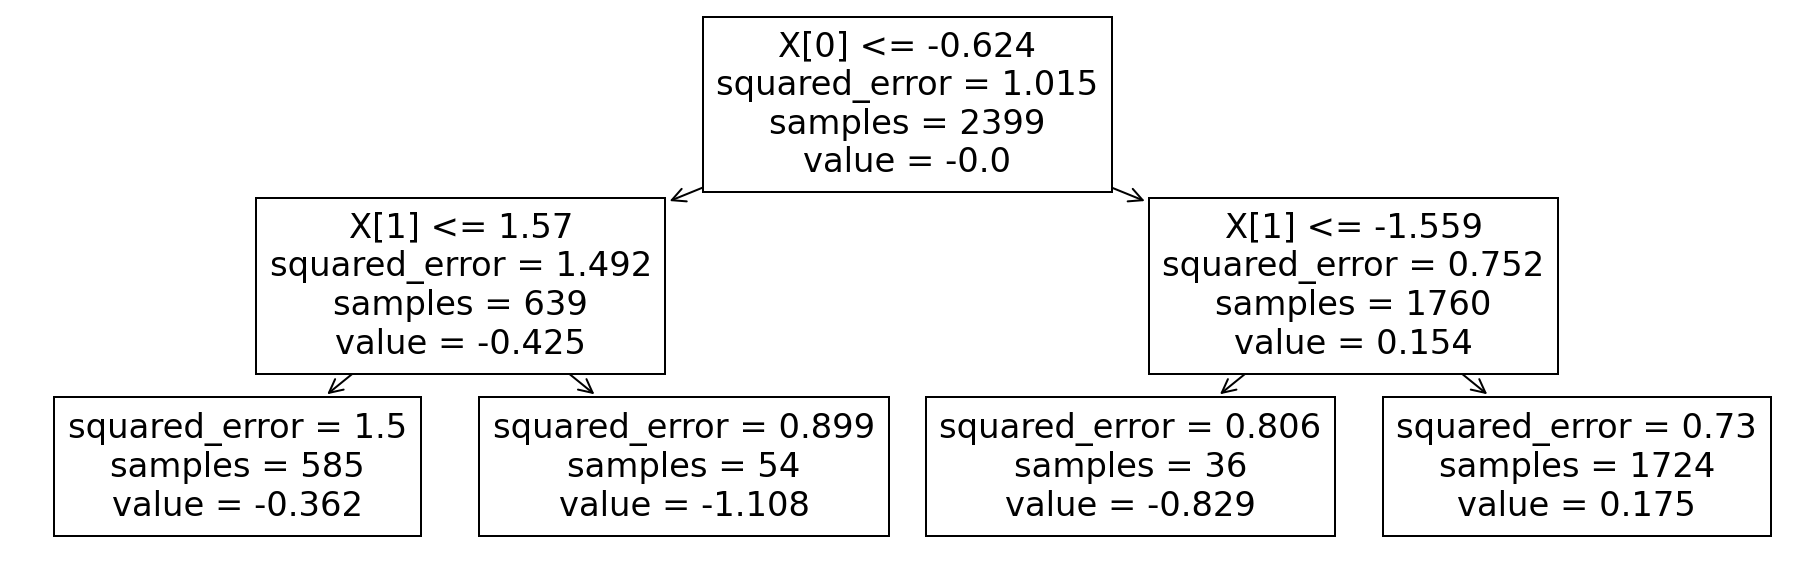

In [5]:
import matplotlib as mpl
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

mpl.rcParams["figure.figsize"] = (16,5)

_ = plot_tree(model)

In [6]:
model.score(Xtrain, ytrain)

0.09044789415074661

In [7]:
Xtest = df[df.date=='2022-01'][["roeq", "mom12m"]]
ytest = df[df.date=='2022-01']["ret"]
model.score(Xtest, ytest)

0.007294268196216702

In [8]:
import seaborn as sns
sns.set_style("whitegrid")
train_scores = []
test_scores = []
import numpy as np
grid = np.arange(2, 22, 2)
for depth in grid:
  model = DecisionTreeRegressor(
  max_depth=depth,
  random_state=0
  )
  _=model.fit(Xtrain, ytrain)
  train_scores.append(model.score(Xtrain, ytrain))
  test_scores.append(model.score(Xtest, ytest))

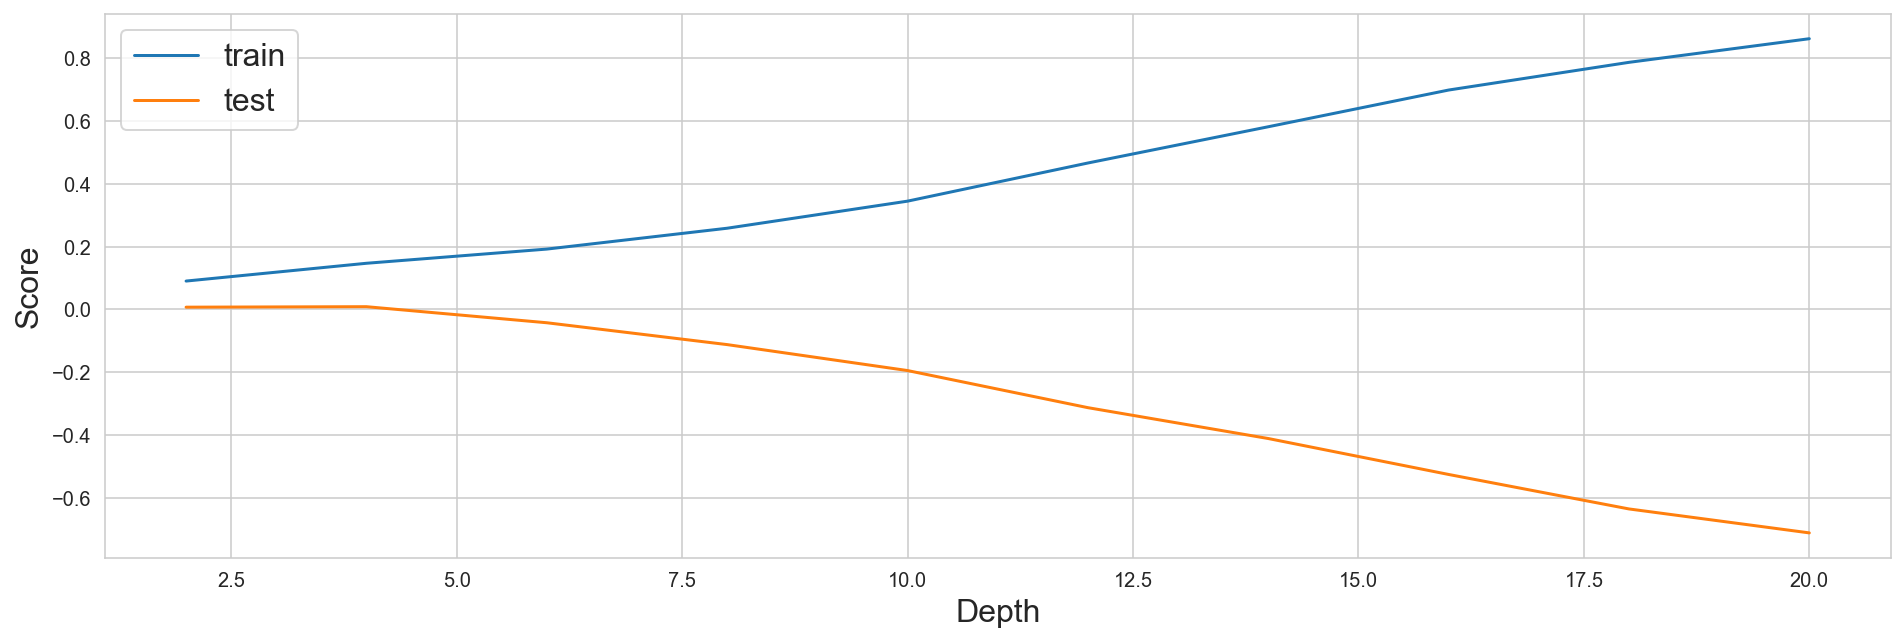

In [9]:
plt.plot(grid, train_scores, label="train")
plt.plot(grid, test_scores, label="test")
plt.xlabel("Depth", fontsize=16)
plt.ylabel("Score", fontsize=16)
_ = plt.legend(fontsize=16)